# (Wang, 2002) Decision making spiking model

Implementation of the paper:

- Wang, Xiao-Jing. "Probabilistic decision making by slow reverberation in cortical circuits." Neuron 36.5 (2002): 955-968.

In [1]:
# -*- coding: utf-8 -*-
import brainpy as bp
import numpy as np
import bpmodels
import matplotlib.pyplot as plt

In [2]:
# set params
# set global params
dt = 0.05  # ms
method = 'exponential'
bp.profile.set(jit=True,
               device='cpu',
               dt=dt,
               numerical_method=method)

# set network params
base_N_E = 1600
base_N_I = 400
net_scale = 5.
N_E = int(base_N_E // net_scale)
N_I = int(base_N_I // net_scale)

f = 0.15  # Note: proportion of neurons activated by one of the two stimulus
N_A = int(f * N_E)
N_B = int(f * N_E)
N_non = N_E - N_A - N_B  # Note: N_E = N_A + N_B + N_non
print(f"N_E = {N_E} = {N_A} + {N_B} + {N_non}, N_I = {N_I}")
# Note: N_E[0:N_A]: A_group
#       N_E[N_A : N_A+N_B]: B_group
#       N_E[N_A + N_B: N_E]: non of A or B

time_scale = 1.
pre_period = 100. / time_scale
stim_period = 1000.
delay_period = 500. / time_scale
total_period = pre_period + stim_period + delay_period

N_E = 320 = 48 + 48 + 224, N_I = 80


In [3]:
# set LIF neu params
V_rest_E = -70.      # mV
V_reset_E = -55.     # mV
V_th_E = -50.        # mV
g_E = 25. * 1e-3     # uS
R_E = 1 / g_E        # MOhm
C_E = 0.5            # nF
tau_E = 20.          # ms
t_refractory_E = 2.  # ms
print(f"R_E * C_E = {R_E * C_E} should be equal to tau_E = {tau_E}")

V_rest_I = -70.      # mV
V_reset_I = -55.     # mV
V_th_I = -50.        # mV
g_I = 20. * 1e-3     # uS
R_I = 1 / g_I        # Mohm
C_I = 0.2            # nF
tau_I = 10.          # ms
t_refractory_I = 1.  # ms
print(f"R_I * C_I = {R_I * C_I} should be equal to tau_I = {tau_I}")


def get_LIF(V_rest=0., V_reset=-5., V_th=20., R=1.,
            tau=10., t_refractory=5., noise=0., mode='scalar'):

    ST = bp.types.NeuState('V', 'input', 'spike',
                           'refractory', t_last_spike=-1e7)

    @bp.integrate
    def int_V(V, t, I_ext):  # integrate u(t)
        return (- (V - V_rest) + R * I_ext) / tau, noise / tau

    def update(ST, _t):
        # update variables
        ST['spike'] = 0.
        if _t - ST['t_last_spike'] <= t_refractory:
            ST['refractory'] = 1.
        else:
            ST['refractory'] = 0.
            V = int_V(ST['V'], _t, ST['input'])
            if V >= V_th:
                V = V_reset
                ST['spike'] = 1
                ST['t_last_spike'] = _t
            ST['V'] = V

    def reset(ST):
        ST['input'] = 0.  # reset input here or it will be brought to next step

    return bp.NeuType(name='LIF_neuron',
                      ST=ST,
                      steps=(update, reset),
                      mode=mode)

R_E * C_E = 20.0 should be equal to tau_E = 20.0
R_I * C_I = 10.0 should be equal to tau_I = 10.0


In [4]:
# set syn params
E_AMPA = 0.            # mV
tau_decay_AMPA = 2     # ms

E_NMDA = 0.            # mV
alpha_NMDA = 0.062     # \
beta_NMDA = 3.57       # \
cc_Mg_NMDA = 1.        # mM
a_NMDA = 0.5           # kHz/ms^-1
tau_rise_NMDA = 2.     # ms
tau_decay_NMDA = 100.  # ms

E_GABAa = -70.         # mV
tau_decay_GABAa = 5.   # ms

delay_syn = 0.5        # ms


def get_NMDA(g_max=0., E=E_NMDA, alpha=alpha_NMDA, beta=beta_NMDA,
             cc_Mg=cc_Mg_NMDA, a=a_NMDA,
             tau_decay=tau_decay_NMDA, tau_rise=tau_rise_NMDA,
             mode='vector'):

    ST = bp.types.SynState('s', 'x', 'g')

    requires = dict(
        pre=bp.types.NeuState(['spike']),
        post=bp.types.NeuState(['V', 'input'])
    )

    @bp.integrate
    def int_x(x, t):
        return -x / tau_rise

    @bp.integrate
    def int_s(s, t, x):
        return -s / tau_decay + a * x * (1 - s)

    if mode == 'scalar':
        def update(ST, _t, pre):
            x = int_x(ST['x'], _t)
            x += pre['spike']
            s = int_s(ST['s'], _t, x)
            ST['x'] = x
            ST['s'] = s
            ST['g'] = g_max * s

        @bp.delayed
        def output(ST, post):
            I_syn = ST['g'] * (post['V'] - E)
            g_inf = 1 / (1 + cc_Mg / beta * np.exp(-alpha * post['V']))
            post['input'] -= I_syn * g_inf

    elif mode == 'vector':
        requires['pre2syn'] = bp.types.ListConn(
            help='Pre-synaptic neuron index -> synapse index')
        requires['post2syn'] = bp.types.ListConn(
            help='Post-synaptic neuron index -> synapse index')

        def update(ST, _t, pre, pre2syn):
            for pre_id in range(len(pre2syn)):
                if pre['spike'][pre_id] > 0.:
                    syn_ids = pre2syn[pre_id]
                    ST['x'][syn_ids] += 1.
            x = int_x(ST['x'], _t)
            s = int_s(ST['s'], _t, x)
            ST['x'] = x
            ST['s'] = s
            ST['g'] = g_max * s

        @bp.delayed
        def output(ST, post, post2syn):
            g = np.zeros(len(post2syn), dtype=np.float_)
            for post_id, syn_ids in enumerate(post2syn):
                g[post_id] = np.sum(ST['g'][syn_ids])
            I_syn = g * (post['V'] - E)
            g_inf = 1 / (1 + cc_Mg / beta * np.exp(-alpha * post['V']))
            post['input'] -= I_syn * g_inf

    elif mode == 'matrix':
        requires['conn_mat'] = bp.types.MatConn()

        def update(ST, _t, pre, conn_mat):
            x = int_x(ST['x'], _t)
            for i in range(pre['spike'].shape[0]):
                if pre['spike'][i] > 0.:
                    x[i] += conn_mat[i]
            s = int_s(ST['s'], _t, x)
            ST['x'] = x
            ST['s'] = s
            ST['g'] = g_max * s

        @bp.delayed
        def output(ST, post):
            g = np.sum(ST['g'], axis=0)
            I_syn = g * (post['V'] - E)
            g_inf = 1 / (1 + cc_Mg / beta * np.exp(-alpha * post['V']))
            post['input'] -= I_syn * g_inf

    else:
        raise ValueError("BrainPy does not support mode '%s'." % (mode))

    return bp.SynType(name='NMDA_synapse',
                      ST=ST,
                      requires=requires,
                      steps=(update, output),
                      mode=mode)

In [5]:
# set syn weights (only used in recurrent E connections)
w_pos = 1.7
w_neg = 1. - f * (w_pos - 1.) / (1. - f)
print(f"the structured weight is: w_pos = {w_pos}, w_neg = {w_neg}")
# inside select group: w = w+
# between group / from non-select group to select group: w = w-
# A2A B2B w+, A2B B2A w-, non2A non2B w-
weight_NMDA = np.ones((N_E, N_E), dtype=np.float)
for i in range(N_A):
    weight_NMDA[i, 0: N_A] = w_pos
    weight_NMDA[i, N_A: N_A + N_B] = w_neg
for i in range(N_A, N_A+N_B):
    weight_NMDA[i, N_A: N_A + N_B] = w_pos
    weight_NMDA[i, 0: N_A] = w_neg
for i in range(N_A + N_B, N_E):
    weight_NMDA[i, 0: N_A + N_B] = w_neg

weight_AMPA = np.ones((N_E, N_E), dtype=np.float)
for i in range(N_A):
    weight_AMPA[i, 0: N_A] = w_pos
    weight_AMPA[i, N_A: N_A + N_B] = w_neg
for i in range(N_A, N_A+N_B):
    weight_AMPA[i, N_A: N_A + N_B] = w_pos
    weight_AMPA[i, 0: N_A] = w_neg

# use different weights for AMPA and NMDA
print(f"Check contraints: Weight sum {weight_NMDA.sum(axis=0)[0]} \
        should be equal to N_E = {N_E}")

the structured weight is: w_pos = 1.7, w_neg = 0.8764705882352941
Check contraints: Weight sum 319.9999999999997         should be equal to N_E = 320


In [6]:
# set background params
poisson_freq = 2400.            # Hz
g_max_ext2E_AMPA = 2.1 * 1e-3   # uS
g_max_ext2I_AMPA = 1.62 * 1e-3  # uS

g_max_E2E_AMPA = 0.05  * 1e-3 * net_scale
g_max_E2E_NMDA = 0.165 * 1e-3 * net_scale
g_max_E2I_AMPA = 0.04  * 1e-3 * net_scale
g_max_E2I_NMDA = 0.13  * 1e-3 * net_scale
g_max_I2E_GABAa = 1.3  * 1e-3 * net_scale
g_max_I2I_GABAa = 1.0  * 1e-3 * net_scale

LIF_neu = get_LIF()
AMPA_syn = bpmodels.synapses.get_AMPA1(mode='matrix')
NMDA_syn = get_NMDA(mode='matrix')
GABAa_syn = bpmodels.synapses.get_GABAa1(mode='matrix')

In [7]:
# def neurons
# def E neurons/pyramid neurons
neu_E = bp.NeuGroup(model=LIF_neu, geometry=N_E,
                    monitors=['spike', 'input', 'V'])
neu_E.set_schedule(['input', 'update', 'monitor', 'reset'])
neu_E.pars['V_rest'] = V_rest_E
neu_E.pars['V_reset'] = V_reset_E
neu_E.pars['V_th'] = V_th_E
neu_E.pars['R'] = R_E
neu_E.pars['tau'] = tau_E
neu_E.pars['t_refractory'] = t_refractory_E
neu_E.ST['V'] = V_rest_E

# def I neurons/interneurons
neu_I = bp.NeuGroup(model=LIF_neu, geometry=N_I, monitors=['input', 'V'])
neu_I.set_schedule(['input', 'update', 'monitor', 'reset'])
neu_I.pars['V_rest'] = V_rest_I
neu_I.pars['V_reset'] = V_reset_I
neu_I.pars['V_th'] = V_th_I
neu_I.pars['R'] = R_I
neu_I.pars['tau'] = tau_I
neu_I.pars['t_refractory'] = t_refractory_I
neu_I.ST['V'] = V_rest_I

In [8]:
# def synapse connections
## define syn conns between neu_E and neu_I
syn_E2E_AMPA = bp.SynConn(model=AMPA_syn,
                          pre_group=neu_E, post_group=neu_E,
                          conn=bp.connect.All2All(),
                          delay=delay_syn)
syn_E2E_AMPA.pars['g_max'] = g_max_E2E_AMPA * weight_NMDA
syn_E2E_AMPA.pars['E'] = E_AMPA
syn_E2E_AMPA.pars['tau_decay'] = tau_decay_AMPA

syn_E2E_NMDA = bp.SynConn(model=NMDA_syn,
                          pre_group=neu_E, post_group=neu_E,
                          conn=bp.connect.All2All(),
                          delay=delay_syn)
syn_E2E_NMDA.pars['g_max'] = g_max_E2E_NMDA * weight_NMDA
syn_E2E_NMDA.pars['E'] = E_NMDA
syn_E2E_NMDA.pars['alpha'] = alpha_NMDA
syn_E2E_NMDA.pars['beta'] = beta_NMDA
syn_E2E_NMDA.pars['cc_Mg'] = cc_Mg_NMDA
syn_E2E_NMDA.pars['a'] = a_NMDA
syn_E2E_NMDA.pars['tau_decay'] = tau_decay_NMDA
syn_E2E_NMDA.pars['tau_rise'] = tau_rise_NMDA

syn_E2I_AMPA = bp.SynConn(model=AMPA_syn,
                          pre_group=neu_E, post_group=neu_I,
                          conn=bp.connect.All2All(),
                          delay=delay_syn)
syn_E2I_AMPA.pars['g_max'] = g_max_E2I_AMPA
syn_E2I_AMPA.pars['E'] = E_AMPA
syn_E2I_AMPA.pars['tau_decay'] = tau_decay_AMPA

syn_E2I_NMDA = bp.SynConn(model=NMDA_syn,
                          pre_group=neu_E, post_group=neu_I,
                          conn=bp.connect.All2All(),
                          delay=delay_syn)
syn_E2I_NMDA.pars['g_max'] = g_max_E2I_NMDA
syn_E2I_NMDA.pars['E'] = E_NMDA
syn_E2I_NMDA.pars['alpha'] = alpha_NMDA
syn_E2I_NMDA.pars['beta'] = beta_NMDA
syn_E2I_NMDA.pars['cc_Mg'] = cc_Mg_NMDA
syn_E2I_NMDA.pars['a'] = a_NMDA
syn_E2I_NMDA.pars['tau_decay'] = tau_decay_NMDA
syn_E2I_NMDA.pars['tau_rise'] = tau_rise_NMDA

syn_I2E_GABAa = bp.SynConn(model=GABAa_syn,
                           pre_group=neu_I, post_group=neu_E,
                           conn=bp.connect.All2All(),
                           delay=delay_syn)
syn_I2E_GABAa.pars['g_max'] = g_max_I2E_GABAa
syn_I2E_GABAa.pars['E'] = E_GABAa
syn_I2E_GABAa.pars['tau_decay'] = tau_decay_GABAa

syn_I2I_GABAa = bp.SynConn(model=GABAa_syn,
                           pre_group=neu_I, post_group=neu_I,
                           conn=bp.connect.All2All(),
                           delay=delay_syn)
syn_I2I_GABAa.pars['g_max'] = g_max_I2I_GABAa
syn_I2I_GABAa.pars['E'] = E_GABAa
syn_I2I_GABAa.pars['tau_decay'] = tau_decay_GABAa

In [9]:
## def background poisson input
neu_poisson = bp.inputs.PoissonInput(geometry=N_E + N_I, freqs=poisson_freq)
syn_back2E_AMPA = bp.SynConn(model=AMPA_syn,
                             pre_group=neu_poisson[:N_E],
                             post_group=neu_E,
                             conn=bp.connect.One2One())
syn_back2E_AMPA.pars['g_max'] = g_max_ext2E_AMPA
syn_back2E_AMPA.pars['E'] = E_AMPA
syn_back2E_AMPA.pars['tau_decay'] = tau_decay_AMPA

syn_back2I_AMPA = bp.SynConn(model=AMPA_syn,
                             pre_group=neu_poisson[N_E:],
                             post_group=neu_I,
                             conn=bp.connect.One2One())
syn_back2I_AMPA.pars['g_max'] = g_max_ext2I_AMPA
syn_back2I_AMPA.pars['E'] = E_AMPA
syn_back2I_AMPA.pars['tau_decay'] = tau_decay_AMPA
# Note: all neurons receive 2400Hz background possion inputs

In [10]:
## def stimulus input
# Note: inputs only given to A and B group
mu_0 = 40.
coherence = 25.6
rou_A = mu_0/100.
rou_B = mu_0/100.
mu_A = mu_0 + rou_A * coherence
mu_B = mu_0 - rou_B * coherence
print(f"coherence = {coherence}, mu_A = {mu_A}, mu_B = {mu_B}")

def get_poisson(t_start=0., t_end=0., t_interval=0., mean_freq=0., var_freq=20., mode='vector'):

    ST = bp.types.NeuState('spike', 'freq', t_last_change=-1e7)

    # neuron model
    dt_ms = bp.profile.get_dt()
    dt_s = dt_ms / 1000.

    def update(ST, _t):
        if _t > t_start and _t < t_end:
            if _t - ST['t_last_change'][0] >= t_interval:
                freq = np.random.normal(mean_freq, var_freq)
                freq = max(freq, 0)
                ST['freq'] = np.ones((ST['spike'].shape)) * freq
                # freq is one value for all neurons in one group at the same time
                #  therefore size is not neu num but 1.
                ST['t_last_change'] = _t
                ST['spike'] = np.random.random(
                    ST['spike'].shape) < ST['freq'] * dt_s
            else:
                ST['spike'] = np.random.random(
                    ST['spike'].shape) < ST['freq'] * dt_s
        else:
            if _t >= t_end and _t <= t_end + dt_ms:
                ST['freq'] = 0.
            ST['spike'] = 0.

    return bp.NeuType(name='poisson_input',
                      ST=ST,
                      steps=update,
                      mode=mode)


possion_neu_2A = get_poisson(t_start=pre_period,
                             t_end=pre_period + stim_period,
                             t_interval=50.,
                             mean_freq=mu_A,
                             var_freq=10.)
possion_neu_2B = get_poisson(t_start=pre_period,
                             t_end=pre_period + stim_period,
                             t_interval=50.,
                             mean_freq=mu_B,
                             var_freq=10.)
neu_input2A = bp.NeuGroup(model=possion_neu_2A,
                          geometry=N_A, monitors=['freq'])
neu_input2B = bp.NeuGroup(model=possion_neu_2B,
                          geometry=N_B, monitors=['freq'])

syn_input2A_AMPA = bp.SynConn(model=AMPA_syn,
                              pre_group=neu_input2A,
                              post_group=neu_E[0:N_A],
                              conn=bp.connect.One2One())
syn_input2A_AMPA.pars['g_max'] = g_max_ext2E_AMPA
syn_input2A_AMPA.pars['E'] = E_AMPA
syn_input2A_AMPA.pars['tau_decay'] = tau_decay_AMPA

syn_input2B_AMPA = bp.SynConn(model=AMPA_syn,
                              pre_group=neu_input2B,
                              post_group=neu_E[N_A:N_A+N_B],
                              conn=bp.connect.One2One())
syn_input2B_AMPA.pars['g_max'] = g_max_ext2E_AMPA
syn_input2B_AMPA.pars['E'] = E_AMPA
syn_input2B_AMPA.pars['tau_decay'] = tau_decay_AMPA

coherence = 25.6, mu_A = 50.24, mu_B = 29.759999999999998


In [11]:
#define and simulate network 
net = bp.Network(neu_poisson,
                 syn_back2E_AMPA, syn_back2I_AMPA,
                 neu_input2A, neu_input2B,
                 syn_input2A_AMPA, syn_input2B_AMPA,
                 neu_E, neu_I,
                 syn_E2E_AMPA, syn_E2E_NMDA,
                 syn_E2I_AMPA, syn_E2I_NMDA,
                 syn_I2E_GABAa, syn_I2I_GABAa)
# Note: you may also use .add method of bp.Network to add
#       NeuGroups and SynConns to network

net.run(duration=total_period, inputs=[], report=False)

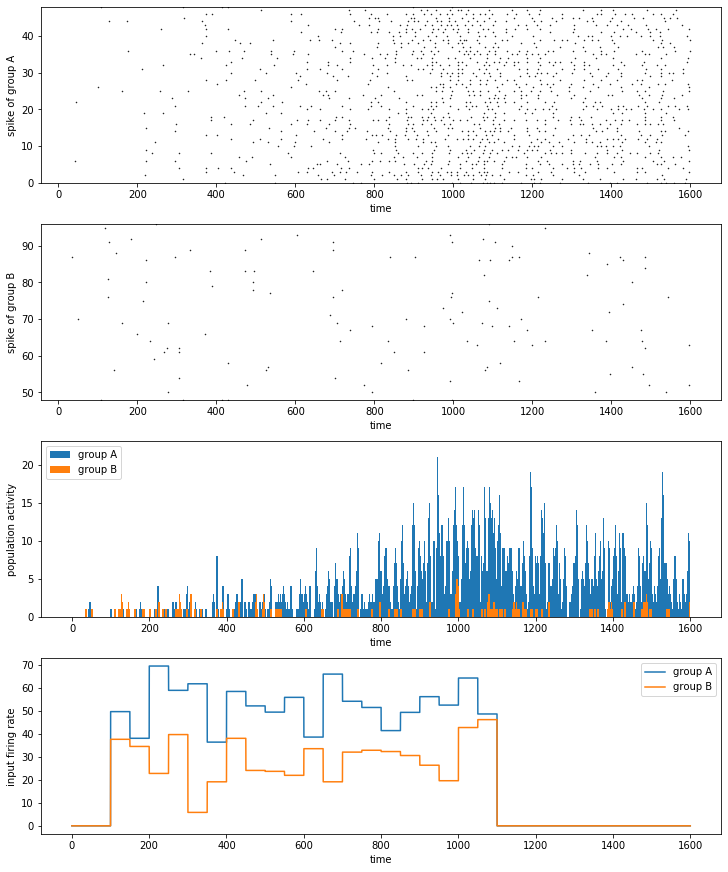

In [12]:
# visualize
def compute_population_fr(data, time_window, time_step):
    spike_cnt_group = data.sum(axis = 1)
    pop_num = data.shape[1]
    time_cnt = int(time_step // bp.profile.get_dt())
    first_step_sum = spike_cnt_group[0:time_cnt].sum(axis = 0)
    pop_fr_group = []
    for t in range(data.shape[0]):
        if t < time_cnt:
            pop_fr_group.append((first_step_sum / time_step)/pop_num)
        else:
            pop_fr_group.append(spike_cnt_group[t - time_cnt:t].sum(axis = 0))
    return pop_fr_group

fig, gs = bp.visualize.get_figure(4, 1, 3, 10)

fig.add_subplot(gs[0, 0])
bp.visualize.raster_plot(net.ts, neu_E.mon.spike, 
                         markersize=1, ylim=[0, N_A])
plt.xlabel("time")
plt.ylabel("spike of group A")
fig.add_subplot(gs[1, 0])
bp.visualize.raster_plot(net.ts, neu_E.mon.spike,
                         markersize=1, ylim=[N_A, N_A + N_B])
plt.xlabel("time")
plt.ylabel("spike of group B")

fig.add_subplot(gs[2, 0])
pop_fr_A = compute_population_fr(neu_E.mon.spike[:, 0:N_A], time_window = 50., time_step = 5.)
pop_fr_B = compute_population_fr(neu_E.mon.spike[:, N_A: N_A+N_B], time_window = 50., time_step = 5.)
plt.bar(net.ts, pop_fr_A, label = "group A")
plt.bar(net.ts, pop_fr_B, label = "group B")
plt.xlabel("time")
plt.ylabel("population activity")
plt.legend()

fig.add_subplot(gs[3, 0])
plt.plot(net.ts, neu_input2A.mon.freq[:, 0], label = "group A")
plt.plot(net.ts, neu_input2B.mon.freq[:, 0], label = "group B")
plt.xlabel("time")
plt.ylabel("input firing rate")
plt.legend()

plt.show()